# Train Classification Model

Steps:
1. split train/test
1. preprocess
    1. tokenize
    1. normalize
1. feature extraction
1. train classification model
1. test model
    1. preprocess and extract features
    1. classify test data
    1. compare against known values


### Load Subset of Clean Wine Reviews

See [data preparation](wine_review-data_preparation.ipynb) for details on the prepared dataset.

Libraries

In [62]:
import os
import string
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

import swifter

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [63]:
wine_df_subset = pd.read_parquet('files/wine_review_subset.parquet.gzip')
wine_df_subset.info()
wine_df_subset.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 32797 to 11496
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1000 non-null   object 
 1   description     1000 non-null   object 
 2   points          1000 non-null   int64  
 3   price           964 non-null    float64
 4   taster_name     1000 non-null   object 
 5   title           1000 non-null   object 
 6   variety         1000 non-null   object 
 7   winery          1000 non-null   object 
 8   year            1000 non-null   int64  
 9   wine_style      1000 non-null   object 
 10  type            1000 non-null   object 
 11  quality         1000 non-null   object 
 12  classification  1000 non-null   object 
 13  location        1000 non-null   object 
 14  band            964 non-null    object 
 15  tokens          1000 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory usage: 132.8+ KB


,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,tokens
32797,US,"Perfumed in rose and violet, with a sauvage sc...",90,30.0,Virginie Boone,Row Eleven 2013 Dutton Sanchietti Pinot Noir (...,Pinot Noir,Row Eleven,2013,light_red,red,high,New World,California,super,perfum rose violet sauvag scent musk distinct ...
105190,US,"This is a very lush Cab, made in the modern st...",92,70.0,Unknown,Robert Craig 2004 Cabernet Sauvignon (Mount Ve...,Cabernet Sauvignon,Robert Craig,2004,full_red,red,high,New World,California,luxury,thi lush cab made modern style all element cul...
89652,Australia,"Full-bodied and plush in texture, this offers ...",85,8.0,Joe Czerwinski,Yellow Tail 2015 Chardonnay (South Eastern Aus...,Chardonnay,Yellow Tail,2015,full_white,white,medium,New World,South Eastern Australia,value,full-bodi plush textur offer plenti apricot ma...
115814,US,Where else in this country can you find $12 Pi...,87,12.0,Paul Gregutt,Eola Hills 2006 Pinot Noir (Oregon),Pinot Noir,Eola Hills,2006,light_red,red,medium,New World,Oregon,value,where els countri find 12 pinot actual variet ...
93320,US,This shows an old-fashioned Spring Mountain dr...,87,55.0,Unknown,Bougetz 2010 Amaryllis Cabernet Sauvignon (Spr...,Cabernet Sauvignon,Bougetz,2010,full_red,red,medium,New World,California,luxury,thi show old-fashion spring mountain dryness t...


In [64]:
# inspect the number of target classes in the reduced dataset
wine_df_subset[['points', 'quality', 'band', 'wine_style', 'variety']].describe(include=object)

,quality,band,wine_style,variety
count,1000,964,1000,1000
unique,2,8,3,3
top,medium,ultra,light_red,Pinot Noir
freq,521,282,393,393


### Train-Test Data Split

In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(wine_df_subset.drop(['price', 'band', 'quality', 'points', 'taster_name', 'title', 'winery', 'location'], axis=1), wine_df_subset.quality, test_size=0.2, random_state=42)

**TODO**: figure out how to handle unknown categories in test set, such as `taster_name`, `title`, `winery`, `location`

**Feature Matrix**

In [66]:
X_train.head()

,country,description,variety,year,wine_style,type,classification,tokens
97315,US,Benefitting from 11 months in 40% new French o...,Pinot Noir,2014,light_red,red,New World,benefit 11 month 40 new french oak open aroma ...
95592,US,Accompanying the raspberry and cranberry are g...,Pinot Noir,2010,light_red,red,New World,accompani raspberri cranberri green mint veget...
91744,New Zealand,This comes out of the bottle a little tarry an...,Pinot Noir,2013,light_red,red,New World,thi come bottl littl tarri rubberi splash arou...
82364,France,"Full of the fresh acidity of the 2014 vintage,...",Chardonnay,2014,full_white,white,Old World,full fresh acid 2014 vintag light bright wine ...
45585,US,From a vineyard site at the southern end of Oa...,Cabernet Sauvignon,2012,full_red,red,New World,from vineyard site southern end oakvil touch y...


**Target**

In [67]:
y_train.head()

97315      high
95592    medium
91744    medium
82364    medium
45585      high
Name: quality, dtype: object

**Vectorize and Train on `description`**

In [68]:
tokens_pipe = Pipeline([
                    ('vectorizer', CountVectorizer(stop_words='english')),
                    ('scaler', StandardScaler(with_mean=False)),
                    ('classifier', LogisticRegression(random_state=42))
                ])
tokens_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', LogisticRegression(random_state=42))])

## **FIXME**: Remove the StandardScaler

LogisticRegression - importance of each column, word
RandomForest - feature importance, top 3 features
XG Boost feature importance
SHAP Values - explanability


subset for develop code

Lemmatization vs. Stemming

Models
  - Basic block: Decision Tree
  - SVM & LR, OVO and OVR
  - Ensemble: RandomForest(bagging) and XGBoost (boosting)
  - Neural Network Classifier

Hugging Face: their own transformer library. club association. ask chatgpt
Data set does not have rich information

Commitments:
  - slide
  - ReadME
  - Jupyter Notebook
  - Insights from EDA
    - see capstone checklist
       - use numbers, with mean age...
       - 

In [ ]:
tokens_pipe.fit(X_train.description, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', LogisticRegression(random_state=42))])

In [70]:
print(f'Accuracy on training data: {tokens_pipe.score(X_train.tokens, y_train):.1%}')

Accuracy on training data: 77.5%


In [71]:
print(f'Accuracy on test data: {tokens_pipe.score(X_test.tokens, y_test):.1%}')

Accuracy on test data: 58.0%


### Feature Extraction

**Define Feature Grouping for Preprocessing**

In [72]:
num_cols = X_train.select_dtypes(np.number).columns.to_list()
num_cols

['year']

In [73]:
cat_cols = X_train.select_dtypes(object).columns.drop(['description','tokens']).to_list()
cat_cols

['country', 'variety', 'wine_style', 'type', 'classification']

**Column Transformer Builder**

In [74]:
# helper function to create transformer for machine learning pipeline given a vectorizer
def create_transformer(vectorizer = CountVectorizer()):
  transformer = make_column_transformer(
    (OneHotEncoder(), cat_cols), 
    (Pipeline([('vect', vectorizer), ('scale', StandardScaler(with_mean=False))]), 'tokens'),
    remainder=StandardScaler()
  )
  return transformer

In [75]:
transformer = create_transformer(CountVectorizer())
transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['country', 'variety', 'wine_style', 'type',
                                  'classification']),
                                ('pipeline',
                                 Pipeline(steps=[('vect', CountVectorizer()),
                                                 ('scale',
                                                  StandardScaler(with_mean=False))]),
                                 'tokens')])

**Pipeline Builder**

In [76]:
# helper function to create a machine learning pipeline given a vectorizer and a classifier
def create_pipeline(vectorizer = CountVectorizer(), classifier = LogisticRegression()):
  pipe = Pipeline([('transform', create_transformer(vectorizer)), ('classify', classifier)])
  return pipe

In [77]:
pipe = create_pipeline(vectorizer = CountVectorizer(), classifier = LogisticRegression())
pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['country', 'variety',
                                                   'wine_style', 'type',
                                                   'classification']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer()),
                                                                  ('scale',
                                                                   StandardScaler(with_mean=False))]),
                                                  'tokens')])),
                ('classify', LogisticRegression())])

### Train Classifier

**CountVectorizer + Logistic Regression**

In [78]:
cvect_lr_pipe = create_pipeline(CountVectorizer(), LogisticRegression()).fit(X_train[cat_cols+num_cols+['tokens']], y_train)
cvect_lr_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['country', 'variety',
                                                   'wine_style', 'type',
                                                   'classification']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer()),
                                                                  ('scale',
                                                                   StandardScaler(with_mean=False))]),
                                                  'tokens')])),
                ('classify', LogisticRegression())])

In [79]:
print(f'Accuracy on training data: {cvect_lr_pipe.score(X_train[cat_cols+num_cols+["tokens"]], y_train):.1%}')

Accuracy on training data: 100.0%


In [80]:
print(f'Accuracy on test data: {cvect_lr_pipe.score(X_test[cat_cols+num_cols+["tokens"]], y_test):.1%}')

Accuracy on test data: 74.0%


**Performance Metric**

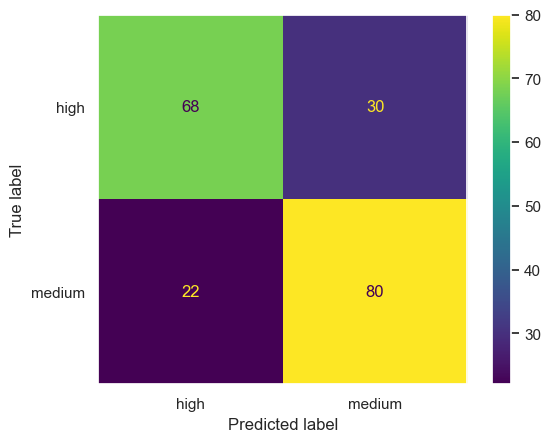

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(cvect_lr_pipe, X_test[cat_cols+num_cols+['tokens']], y_test)
plt.grid(False)

**Performance Metric**

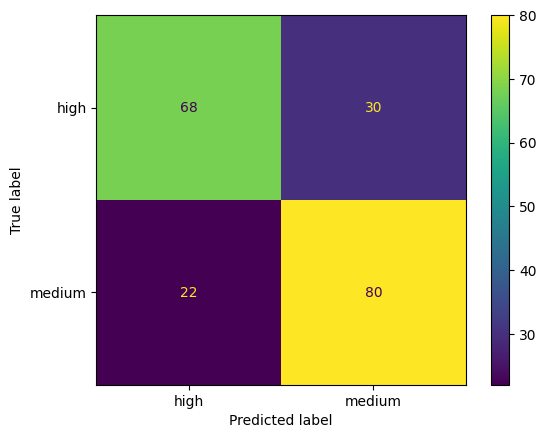

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(cvect_lr_pipe, X_test[cat_cols+num_cols+['tokens']], y_test)

Classifiers to consider:
- K-nearest neighbors
- Multinomial Logistic regression
- Decision trees
- Support vector machine
- Naive Bayes

Performance Metrics:
- Confusion matrix
- Root mean squared error (RMSE)
- F1 score
- Area under the curve (AUC)
- Perplexity
- Metric for Evaluation of Translation with Explicit ORdering (METEOR)
- Recall-Oriented Understudy for Gisting Evaluation (ROUGE)


# Next
- [ ] compare multiple models
- [ ] tune hyperparameters for various models
- [ ] explore ensemble approach
- [ ] neural network
- [ ] Explore [Hugging Face](https://huggingface.co/), synonyms?